# Spaceship Titanic

The goal of this project is to build a model that predicts which passengers were transported from the Spaceship Titanic with the greatest possible accuracy.

## 1. Imports and EDA

In [1]:
import matplotlib.pyplot as plt

import pandas as pd

import seaborn as sns

from sklearn.compose import ColumnTransformer
from sklearn.dummy import DummyClassifier
from sklearn.ensemble import StackingClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC

from xgboost import XGBClassifier

In [2]:
train_df = pd.read_csv('train.csv')

In [3]:
submission_df = pd.read_csv('test.csv')

In [4]:
train_df.head()

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,False
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines,True


In [5]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8693 entries, 0 to 8692
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   PassengerId   8693 non-null   object 
 1   HomePlanet    8492 non-null   object 
 2   CryoSleep     8476 non-null   object 
 3   Cabin         8494 non-null   object 
 4   Destination   8511 non-null   object 
 5   Age           8514 non-null   float64
 6   VIP           8490 non-null   object 
 7   RoomService   8512 non-null   float64
 8   FoodCourt     8510 non-null   float64
 9   ShoppingMall  8485 non-null   float64
 10  Spa           8510 non-null   float64
 11  VRDeck        8505 non-null   float64
 12  Name          8493 non-null   object 
 13  Transported   8693 non-null   bool   
dtypes: bool(1), float64(6), object(7)
memory usage: 891.5+ KB


In [6]:
train_df_len = len(train_df)
submission_df_len = len(submission_df)

In [7]:
def combine_df(train_df, submission_df):
    combined_df = pd.concat([train_df, submission_df], ignore_index=True)
    return combined_df

def separate_df(combined_df, train_df_len, test_df_len):
    train_df = combined_df.iloc[:train_df_len]
    submission_df = combined_df.iloc[train_df_len:train_df_len + test_df_len]
    return train_df, test_df

full_df = combine_df(train_df, submission_df)
len(full_df)

12970

In [8]:
train_df['HomePlanet'].value_counts()

Earth     4602
Europa    2131
Mars      1759
Name: HomePlanet, dtype: int64

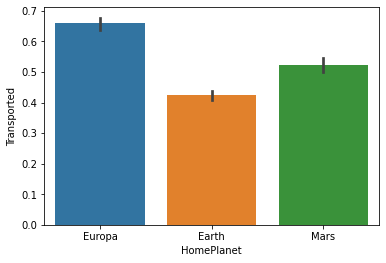

In [9]:
sns.barplot(x='HomePlanet',y='Transported',data=train_df);

In [10]:
train_df['CryoSleep'].value_counts()

False    5439
True     3037
Name: CryoSleep, dtype: int64

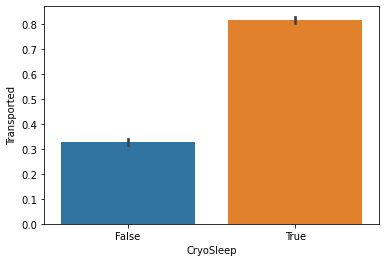

In [11]:
sns.barplot(x='CryoSleep',y='Transported',data=train_df);

In [12]:
full_df.loc[full_df['CryoSleep'] == True, ['RoomService','ShoppingMall','FoodCourt','Spa','VRDeck']] = full_df.loc[full_df['CryoSleep'] == True, ['RoomService','ShoppingMall','FoodCourt','Spa','VRDeck']].fillna(0)

In [13]:
cabin_counts = full_df['Cabin'].value_counts()

In [14]:
cabin_df = pd.DataFrame({'cabin' : cabin_counts.index, 'people in cabin' : cabin_counts.values})

In [15]:
cabin_df

,cabin,people in cabin
0,G/734/S,8
1,G/160/P,8
2,G/748/S,7
3,B/82/S,7
4,E/13/S,7
...,...,...
9820,G/921/P,1
9821,F/1009/P,1
9822,G/1272/P,1
9823,F/417/S,1


In [16]:
full_df = full_df.merge(cabin_df, left_on = 'Cabin', right_on = 'cabin', how = 'left')

In [17]:
full_df.drop('cabin',axis=1,inplace=True)

In [18]:
cabin_split = full_df['Cabin'].str.split('/', expand=True)
cabin_split.columns = ['Deck','Room_Number','Side']
full_df = pd.concat([full_df, cabin_split], axis = 1)
full_df.drop(columns=['Cabin'], inplace = True)
full_df.head()

,PassengerId,HomePlanet,CryoSleep,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported,people in cabin,Deck,Room_Number,Side
0,0001_01,Europa,False,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False,1.0,B,0,P
1,0002_01,Earth,False,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True,1.0,F,0,S
2,0003_01,Europa,False,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False,2.0,A,0,S
3,0003_02,Europa,False,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,False,2.0,A,0,S
4,0004_01,Earth,False,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines,True,1.0,F,1,S


In [19]:
train_df['Destination'].value_counts()

TRAPPIST-1e      5915
55 Cancri e      1800
PSO J318.5-22     796
Name: Destination, dtype: int64

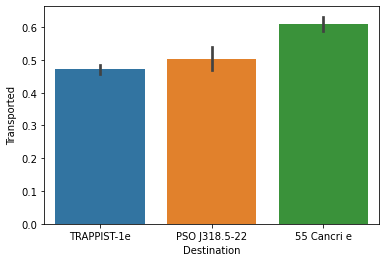

In [20]:
sns.barplot(x='Destination',y='Transported',data=train_df);

In [21]:
train_df['VIP'].value_counts()

False    8291
True      199
Name: VIP, dtype: int64

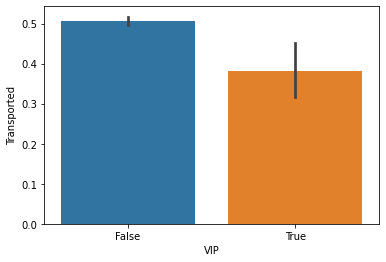

In [22]:
sns.barplot(x='VIP',y='Transported',data=train_df);

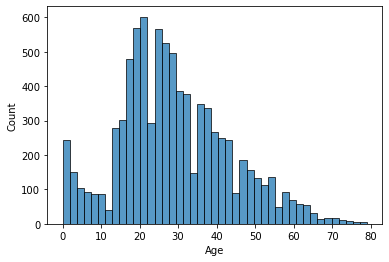

In [23]:
sns.histplot(x='Age',data=train_df);

In [24]:
train_df['Age_bins'] = pd.cut(train_df['Age'],bins=10)

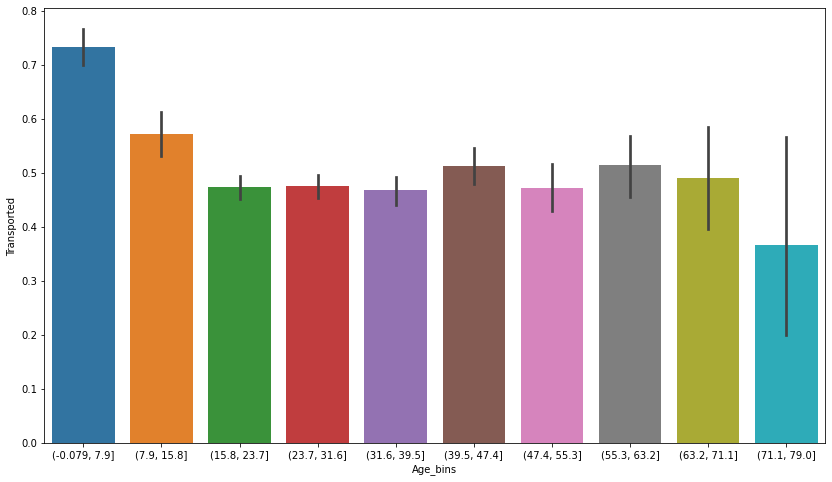

In [25]:
plt.figure(figsize=(14,8))
sns.barplot(x='Age_bins',y='Transported',data=train_df);

In [26]:
full_df.loc[full_df['Age']<8,'Child'] = 1
full_df.loc[full_df['Age']>=8,'Child'] = 0

In [27]:
train_df.describe()

,Age,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck
count,8514.000000,8512.000000,8510.000000,8485.000000,8510.000000,8505.000000
mean,28.827930,224.687617,458.077203,173.729169,311.138778,304.854791
std,14.489021,666.717663,1611.489240,604.696458,1136.705535,1145.717189
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,19.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,27.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,38.000000,47.000000,76.000000,27.000000,59.000000,46.000000
max,79.000000,14327.000000,29813.000000,23492.000000,22408.000000,24133.000000


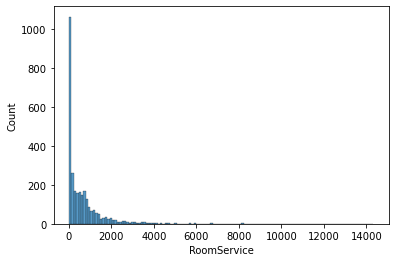

In [28]:
sns.histplot(x='RoomService',data=train_df[train_df['RoomService']!=0]);

In [29]:
full_df.loc[full_df['RoomService']==0,'RoomServiceSpending'] = 0
full_df.loc[full_df['RoomService']!=0,'RoomServiceSpending'] = 1

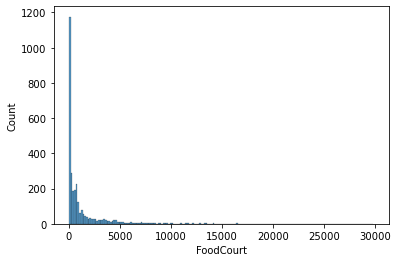

In [30]:
sns.histplot(x='FoodCourt',data=train_df[train_df['FoodCourt']!=0]);

In [31]:
full_df.loc[full_df['FoodCourt']==0,'FoodCourtSpending'] = 0
full_df.loc[full_df['FoodCourt']!=0,'FoodCourtSpending'] = 1

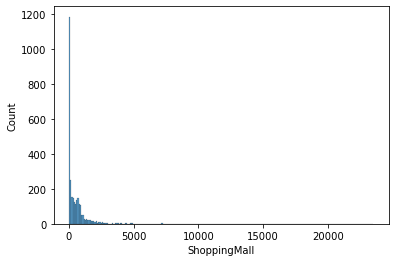

In [32]:
sns.histplot(x='ShoppingMall',data=train_df[train_df['ShoppingMall']!=0]);

In [33]:
full_df.loc[full_df['ShoppingMall']==0,'ShoppingMallSpending'] = 0
full_df.loc[full_df['ShoppingMall']!=0,'ShoppingMallSpending'] = 1

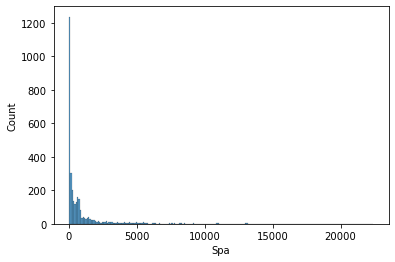

In [34]:
sns.histplot(x='Spa',data=train_df[train_df['Spa']!=0]);

In [35]:
full_df.loc[full_df['Spa'] == 0, 'SpaSpending'] = 0
full_df.loc[full_df['Spa'] != 0, 'SpaSpending'] = 1

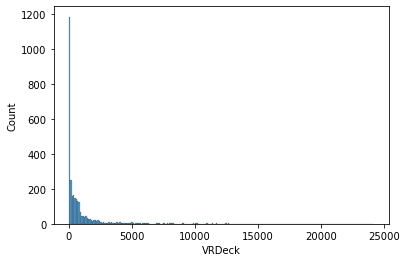

In [36]:
sns.histplot(x='VRDeck',data=train_df[train_df['VRDeck']!=0]);

In [37]:
full_df.loc[full_df['VRDeck'] == 0, 'VRSpending'] = 0
full_df.loc[full_df['VRDeck'] != 0, 'VRSpending'] = 1

In [38]:
full_df['Amenities'] = full_df['VRSpending'] + full_df['SpaSpending'] + full_df['ShoppingMallSpending'] + full_df['FoodCourtSpending'] + full_df['RoomServiceSpending']

In [39]:
full_df['Amenities'].value_counts()

0.0    5371
3.0    3040
4.0    2078
2.0    1659
5.0     445
1.0     377
Name: Amenities, dtype: int64

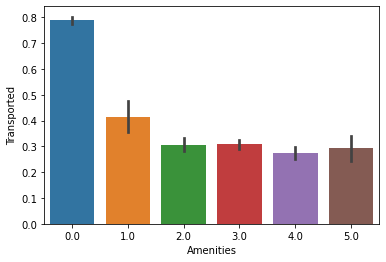

In [40]:
sns.barplot(x='Amenities',y='Transported',data=full_df);

In [41]:
full_df.loc[full_df['Amenities'] == 0, 'AmenityGroup'] = 0
full_df.loc[full_df['Amenities'] == 1, 'AmenityGroup'] = 1
full_df.loc[full_df['Amenities'] >= 2, 'AmenityGroup'] = 2

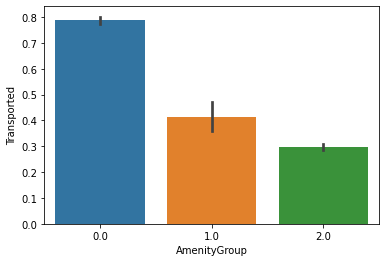

In [42]:
sns.barplot(x='AmenityGroup',y='Transported',data=full_df);

In [43]:
full_df.loc[full_df['Amenities']==0,'CryoSleep'] = full_df.loc[full_df['Amenities']==0,'CryoSleep'].fillna(True)
full_df.loc[full_df['Amenities']!=0,'CryoSleep'] = full_df.loc[full_df['Amenities']!=0,'CryoSleep'].fillna(False)

## 2. Preparing for Modeling

In [44]:
X = train_df.drop('Transported',axis=1)
y = train_df['Transported']

In [45]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size = .2, random_state = 42)

In [46]:
ohecols = ['HomePlanet','CryoSleep','Cabin','Destination','VIP']

In [47]:
numcols = ['Age','RoomService','FoodCourt','ShoppingMall','Spa','VRDeck']

In [48]:
ohe_sub = Pipeline([
    ('cat_impute', SimpleImputer(strategy='most_frequent')),
    ('ohe', OneHotEncoder(sparse=False, handle_unknown='ignore'))
])

In [49]:
num_sub = Pipeline([
    ('num_impute', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())
])

In [50]:
CT = ColumnTransformer(transformers=[
    ('ohe', ohe_sub, ohecols),
    ('num', num_sub, numcols),   
])

## 3. Modeling

### 3a. Dummy

In [51]:
dum_pipe = Pipeline([
    ('ct', CT),
    ('dummy', DummyClassifier(strategy='most_frequent'))
])

In [52]:
dum_pipe.fit(X_train,y_train)

C:\Users\Hendricks\anaconda3\envs\learn-env\lib\site-packages\sklearn\preprocessing\_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


Pipeline(steps=[('ct',
                 ColumnTransformer(transformers=[('ohe',
                                                  Pipeline(steps=[('cat_impute',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ohe',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse=False))]),
                                                  ['HomePlanet', 'CryoSleep',
                                                   'Cabin', 'Destination',
                                                   'VIP']),
                                                 ('num',
                                                  Pipeline(steps=[('num_impute',
                                                                   SimpleImputer()),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['Age', 'RoomService',
                                                   'FoodCourt', 'ShoppingMall',
                                                   'Spa', 'VRDeck'])])),
                ('dummy', DummyClassifier(strategy='most_frequent'))])

In [53]:
dum_pipe.score(X_test,y_test)

0.5048878665899943

### 3b. Logistic Regression

In [54]:
lr_pipe = Pipeline([
    ('ct', CT),
    ('lr', LogisticRegression())
])

In [55]:
lr_pipe.fit(X_train,y_train)

C:\Users\Hendricks\anaconda3\envs\learn-env\lib\site-packages\sklearn\preprocessing\_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
C:\Users\Hendricks\anaconda3\envs\learn-env\lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Pipeline(steps=[('ct',
                 ColumnTransformer(transformers=[('ohe',
                                                  Pipeline(steps=[('cat_impute',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ohe',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse=False))]),
                                                  ['HomePlanet', 'CryoSleep',
                                                   'Cabin', 'Destination',
                                                   'VIP']),
                                                 ('num',
                                                  Pipeline(steps=[('num_impute',
                                                                   SimpleImputer()),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['Age', 'RoomService',
                                                   'FoodCourt', 'ShoppingMall',
                                                   'Spa', 'VRDeck'])])),
                ('lr', LogisticRegression())])

In [56]:
lr_pipe.score(X_test,y_test)

0.7745830937320299

### 3c. Random Forest

In [57]:
rf_pipe = Pipeline([
    ('ct', CT),
    ('rf', RandomForestClassifier(max_depth = 5))
])

In [58]:
rf_pipe.fit(X_train,y_train)

C:\Users\Hendricks\anaconda3\envs\learn-env\lib\site-packages\sklearn\preprocessing\_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


Pipeline(steps=[('ct',
                 ColumnTransformer(transformers=[('ohe',
                                                  Pipeline(steps=[('cat_impute',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ohe',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse=False))]),
                                                  ['HomePlanet', 'CryoSleep',
                                                   'Cabin', 'Destination',
                                                   'VIP']),
                                                 ('num',
                                                  Pipeline(steps=[('num_impute',
                                                                   SimpleImputer()),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['Age', 'RoomService',
                                                   'FoodCourt', 'ShoppingMall',
                                                   'Spa', 'VRDeck'])])),
                ('rf', RandomForestClassifier(max_depth=5))])

In [59]:
rf_pipe.score(X_test,y_test)

0.7429557216791259

### 3d. XGBoost

In [60]:
xgb_pipe = Pipeline([
    ('ct',CT),
    ('xgb',XGBClassifier(max_depth = 5))
])

In [61]:
xgb_pipe.fit(X_train,y_train)

C:\Users\Hendricks\anaconda3\envs\learn-env\lib\site-packages\sklearn\preprocessing\_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


Pipeline(steps=[('ct',
                 ColumnTransformer(transformers=[('ohe',
                                                  Pipeline(steps=[('cat_impute',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ohe',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse=False))]),
                                                  ['HomePlanet', 'CryoSleep',
                                                   'Cabin', 'Destination',
                                                   'VIP']),
                                                 ('num',
                                                  Pipeline(steps=[('num_impute',
                                                                   SimpleImputer()),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['Age', 'RoomServ...
                               colsample_bytree=1, gamma=0, gpu_id=-1,
                               importance_type='gain',
                               interaction_constraints='',
                               learning_rate=0.300000012, max_delta_step=0,
                               max_depth=5, min_child_weight=1, missing=nan,
                               monotone_constraints='()', n_estimators=100,
                               n_jobs=0, num_parallel_tree=1, random_state=0,
                               reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
                               subsample=1, tree_method='exact',
                               validate_parameters=1, verbosity=None))])

In [62]:
xgb_pipe.score(X_test,y_test)

0.7878090856814262

### 4. Submission

In [63]:
submission_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4277 entries, 0 to 4276
Data columns (total 13 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   PassengerId   4277 non-null   object 
 1   HomePlanet    4190 non-null   object 
 2   CryoSleep     4184 non-null   object 
 3   Cabin         4177 non-null   object 
 4   Destination   4185 non-null   object 
 5   Age           4186 non-null   float64
 6   VIP           4184 non-null   object 
 7   RoomService   4195 non-null   float64
 8   FoodCourt     4171 non-null   float64
 9   ShoppingMall  4179 non-null   float64
 10  Spa           4176 non-null   float64
 11  VRDeck        4197 non-null   float64
 12  Name          4183 non-null   object 
dtypes: float64(6), object(7)
memory usage: 434.5+ KB


In [64]:
passenger_ids = submission_df['PassengerId']

In [65]:
predictions = xgb_pipe.predict(submission_df).astype(bool)

In [66]:
result_df = pd.DataFrame({'PassengerId':passenger_ids,'Transported':predictions})

In [67]:
result_df.to_csv('submission_1.csv',index=False)